# The graph backend

In this tutorial, you will learn how to use `Jaxley`s graph pipeline, which offers interoperability with `networkX`. We will:
- define morphologies via `networkX` graphs.
- export morphologies to `networkX` graphs.
- import morphologies using `Jaxley`'s graph pipeline.

Here is a code snippet which you will learn to understand in this tutorial:

```python
import jaxley as jx
import networkx as nx
from jaxley.io.graph import (
    to_swc_graph, build_compartment_graph, vis_compartment_graph, from_graph
)
from jaxley.modules.base import to_graph

# Import cell from SWC via the graph-backend.
swc_graph = to_swc_graph("tests/swc_files/morph.swc")
comp_graph = build_compartment_graph(swc_graph, ncomp=1)
cell = from_graph(comp_graph)

# Export cell to the graph-backend.
comp_graph = to_graph(cell)
vis_compartment_graph(comp_graph)
```

While `swc` is a great way to save, load and specify complex morphologies, often more flexibility is needed. In these cases, graphs present a natural way to represent and work with neural morphologies, allowing for easy fixing, pruning, smoothing and traversal of neural morphologies. For this purpose, `Jaxley`  comes with a [`networkX`](https://networkx.org/documentation/stable/index.html) toolset that allows for easy interoperability between `networkX` graphs and `Jaxley` Modules.

To work with complex morphologies, `jaxley.io.graph` provides a way to import `swc` reconstructions as graphs:

In [1]:
from jaxley.io.graph import to_swc_graph

fname = "data/morph.swc"
swc_graph = to_swc_graph(fname)

A major advantage of this is that having imported an `swc` file as a graph allows to fix, prune, or smooth the morphology. As an example, we remove the apical dendrites of a morphology that we read from `swc`:

In [2]:
import networkx as nx

# manipulate the graph
ids = nx.get_node_attributes(swc_graph, "id")
ids = {k: v for k, v in ids.items() if v != 4}  # Apical dendrite has `id=4`: http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html 
swc_graph = nx.subgraph(swc_graph, ids).copy()

We can then visualize the remaining morphology:

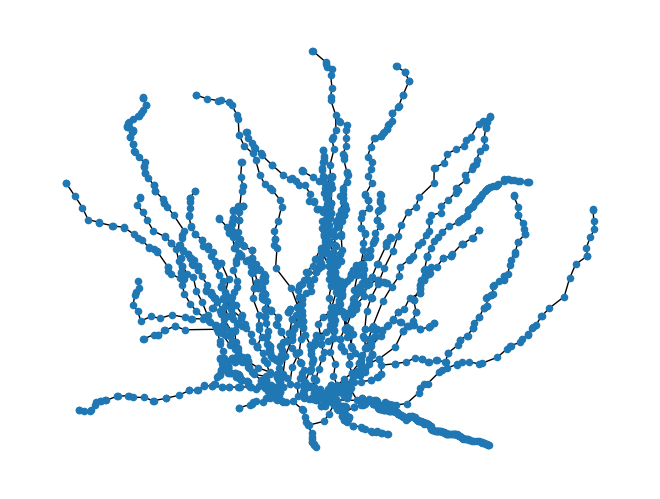

In [3]:
pos = {k: (v["x"], v["y"]) for k, v in swc_graph.nodes.items()}
nx.draw(swc_graph.to_undirected(), pos=pos, node_size=20)

Next, we compartmentalize this graph. To this end, `build_compartment_graph()` segments the SWC graph into branches and divides the branches up into compartments.

In [4]:
from jaxley.io.graph import build_compartment_graph

comp_graph = build_compartment_graph(swc_graph, ncomp=2)

You can view the compartment structure as follows:

node attributes {'x': 2.311556339263916, 'y': -8.913771629333496, 'z': 0.0, 'branch_index': 0, 'comp_index': 0, 'type': 'comp', 'xyzr': array([[  4.06      , -11.45      ,   0.        ,   2.6       ],
       [  3.        , -10.35      ,   0.        ,   3.86      ],
       [  2.74      ,  -9.85      ,   0.        ,   4.019     ],
       [  2.2       ,  -8.67      ,   0.        ,   4.34      ],
       [  2.17      ,  -8.49      ,   0.        ,   4.34      ],
       [  1.99      ,  -7.26      ,   0.        ,   5.81      ],
       [  1.98      ,  -6.        ,   0.        ,   6.28      ],
       [  1.96899895,  -5.83329182,   0.        ,   6.36039227]]), 'groups': ['soma'], 'radius': 4.542392560157545, 'length': 6.241557163671718, 'cell_index': 0}
edge attributes {}


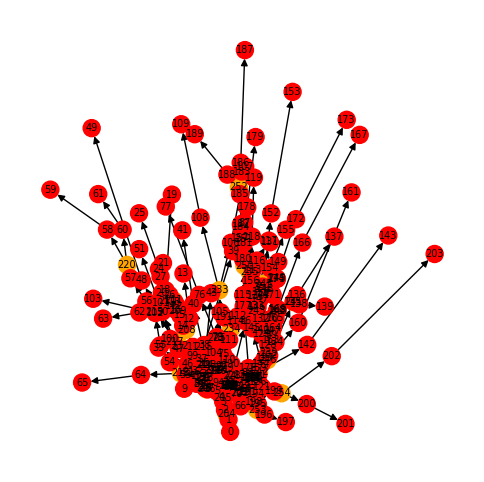

In [5]:
import matplotlib.pyplot as plt
from jaxley.io.graph import vis_compartment_graph

print(f"node attributes {comp_graph.nodes[0]}")
print(f"edge attributes {comp_graph.edges[(0, 1)]}")

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
vis_compartment_graph(comp_graph, ax=ax)

In the graph above, red points indicate compartments and orange points indicate branchpoints.

Now, let's import this graph into `Jaxley`. We use the `from_graph()` function to convert the graph into a `Cell` object, which `Jaxley` can then simulate or optimize.

In [6]:
from jaxley.io.graph import build_compartment_graph, from_graph
from jaxley.channels import HH

cell = from_graph(comp_graph)

# The resulting cell can be treated like any Jaxley cell.
# As an example, we add HH and change parameters for visualization.
cell.insert(HH())
for branch in cell:
    y_pos = branch.xyzr[0][0,1]
    branch.set("HH_gNa", 0.5 + 0.5 * y_pos)

`Jaxley` also offers the option to export any `Module` to a `networkX` graph object:

In [7]:
from jaxley.modules.base import to_graph

comp_graph = to_graph(cell, channels=True)

Exporting a `Jaxley` cell to a graph provides another way to store or share the current Module state, since `to_graph` attaches all relevant attributes to the nodes and eges of the graph. It can also be used to make more complex visualizations: for example, we can visualize the channel density of each compartment as below:

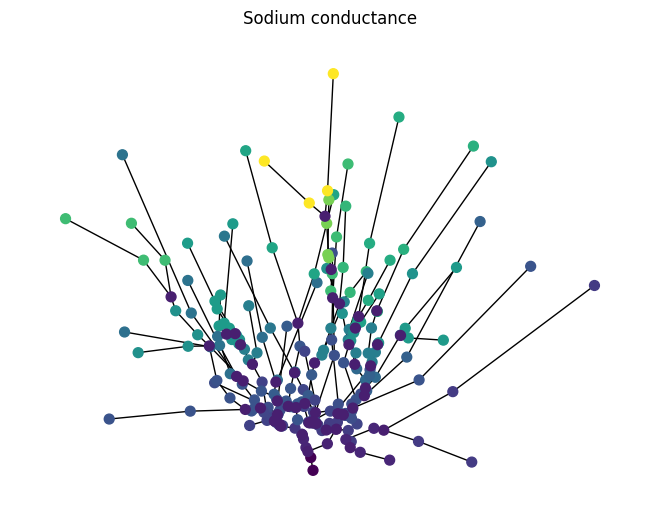

In [8]:
# plot of the cell, coloring each node according to the sodium conductance
pos = {k: (v["x"], v["y"]) for k, v in comp_graph.nodes.items()}
colors = []
for n in comp_graph.nodes:
    if "HH_gNa" in comp_graph.nodes[n]:
        # Color of compartments should scale with HH_gNa.
        colors.append(comp_graph.nodes[n]["HH_gNa"])
    else:
        # Branchpoints have no channels.
        colors.append(0.0)

nx.draw(comp_graph.to_undirected(), pos=pos, node_color=colors, cmap="viridis", with_labels=False, node_size=50)
plt.title("Sodium conductance")
plt.show()

## Editing morphologies

To edit morphologies, `Jaxley` provides `delete_morph` and `attach_morph`. If these do not provide enough flexibility, you can use the graph-backend to modify morphologies. As an example, we will trim all tip dendrites that are shorter than 250 $\mu$m.

First, we import the SWC file as a compartment graph:

In [9]:
from jaxley.io.graph import to_swc_graph, build_compartment_graph

swc_graph = to_swc_graph(fname)
comp_graph = build_compartment_graph(swc_graph, ncomp=1)

Let's visualize it:

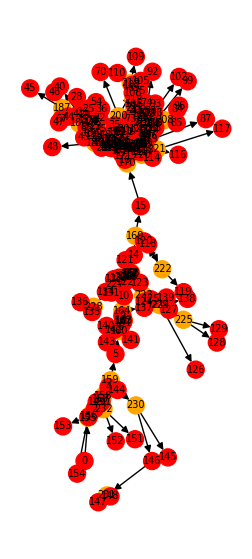

In [10]:
from jaxley.io.graph import vis_compartment_graph

fig, ax = plt.subplots(1, 1, figsize=(3, 7))
vis_compartment_graph(comp_graph, ax=ax)

Next, we loop over all nodes. We want to keep nodes only if they made any of the following conditions:  
- if a node has more than one neighbor (`degree > 1`),  
- if its compartment length is > 250 $\mu$m, or  
- if it is a soma.

In [11]:
import networkx as nx

nodes_to_keep = []
for node in comp_graph.nodes:
    degree = comp_graph.in_degree(node) + comp_graph.out_degree(node)
    
    condition1 = degree > 1
    condition2 = comp_graph.nodes[node]["length"] > 250.0
    condition3 = "soma" in comp_graph.nodes[node]["groups"]
    if condition1 or condition2 or condition3:
        nodes_to_keep.append(node)

comp_graph = nx.subgraph(comp_graph, nodes_to_keep)

We can again visualize the trimmed graph:

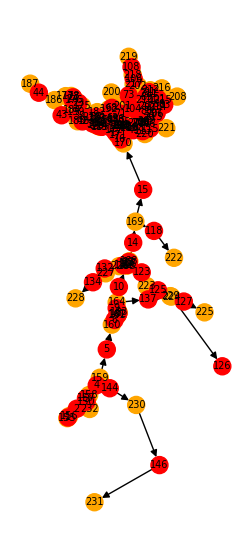

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 7))
vis_compartment_graph(comp_graph, ax=ax)

After we are done, we can import the graph as a `jx.Cell` with the `from_graph` method:

In [13]:
from jaxley.io.graph import from_graph
cell = from_graph(comp_graph)

...and we can also visualize the remaining morphology:

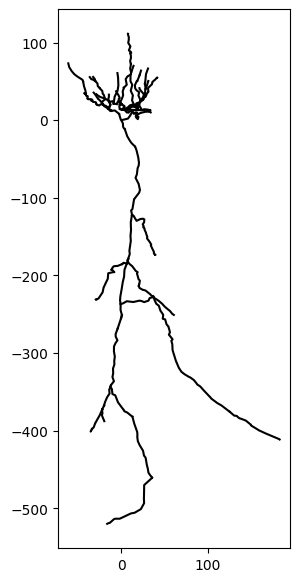

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(3, 7))
_ = cell.vis(ax=ax)

...and we can run simulations as always:

In [15]:
import jaxley as jx

cell.delete_recordings()
cell.delete_stimuli()
cell.soma.branch(0).comp(0).record()
cell.soma.branch(0).comp(0).stimulate(jx.step_current(10.0, 20.0, 0.1, 0.025, 100.0))

Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.


In [16]:
v = jx.integrate(cell)

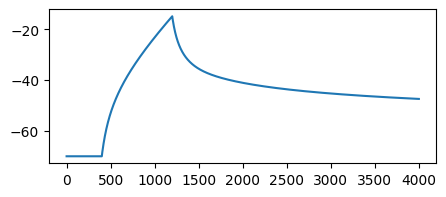

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
_ = ax.plot(v.T)

## Building graphs from scratch

Finally, you can even build graphs completely from scratch in `networkX` and then import them as a `Jaxley` module:

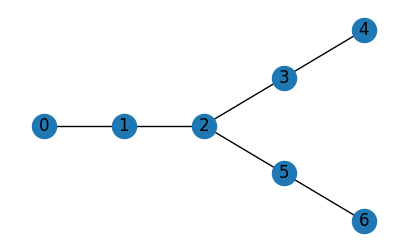

In [18]:
import networkx as nx

nodes = {
    0: {"id":1, "x": -1, "y": 0, "z": 0, "r": 0.2},
    1: {"id":1, "x": 0, "y": 0, "z": 0, "r": 0.2},
    2: {"id":1, "x": 1, "y": 0, "z": 0, "r": 0.2},
    3: {"id":1, "x": 2, "y": 1, "z": 0, "r": 0.1},
    4: {"id":1, "x": 3, "y": 2, "z": 0, "r": 0.1},
    5: {"id":1, "x": 2, "y": -1, "z": 0, "r": 0.1},
    6: {"id":1, "x": 3, "y": -2, "z": 0, "r": 0.1},
} 
edges = ((0, 1),(1, 2),(2, 3),(3, 4),(2, 5),(5, 6))

g = nx.DiGraph()
g.add_nodes_from(nodes.items())
g.add_edges_from(edges, l=1)

# Setting any of these attributes is optional. It is sufficient to define the 
# connectivity and simply do g = nx.DiGraph(edges). In this case, r and l will 
# be set to default values and x, y, z can be computed using Cell.compute_xyz().

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
nx.draw(g.to_undirected(), pos={k: (v["x"], v["y"]) for k, v in nodes.items()}, with_labels=True, ax=ax)

We can then use `io.graph` to import such a graph into a `jx.Module` using the `from_graph` method:

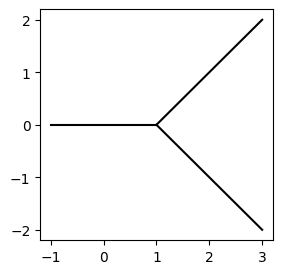

In [19]:
from jaxley.io.graph import build_compartment_graph, from_graph

comp_graph = build_compartment_graph(g, ncomp=2)
cell = from_graph(comp_graph)

cell.vis()
plt.show()

Congrats! You have now learned how to interface with `networkX` to further customize and manipulate imported morphologies.